In [210]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import SGDRegressor
from sklearn.base import clone
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [211]:
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

def fit_model(search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))

    
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()
    
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

## 3) Prediction and Regression
### 3.3) Stochastic Gradient Descent
- - -

In [212]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


### 3.3.1) Regression for Confirmed Cases

### Using normalized values as input and using increments as output
- - -

In [213]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [214]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [215]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [216]:
# create SGDRegressor instance, and check the hyper parameters
sgd = SGDRegressor()
sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [217]:
# hyper parameter tuning was unfeasable for SGDRegressor in normal time
sgd_estimator = sgd
fit_model(sgd_estimator, in_conf_train, out_conf_train)
sgd_estimator

Elapsed time: 0.0006482879320780436mins


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

MAE: 286.4034834847334
MSE: 1442942.5862324191
RMSE: 1201.2254518750503
R^2: 0.01443450759227105


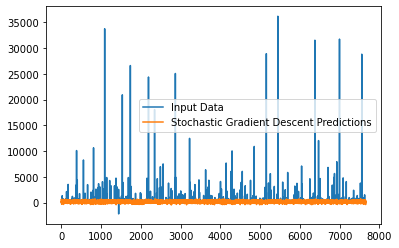

In [218]:
check_results_test(sgd_estimator, in_conf_test, out_conf_test, 'Stochastic Gradient Descent Predictions')

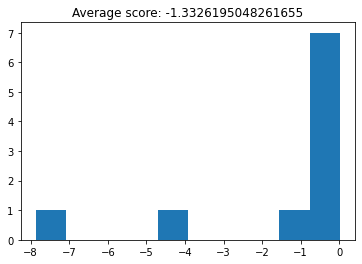

In [219]:
sgd_estimator_2 = clone(sgd_estimator)

plot_cross_val_score(sgd_estimator_2, inputs, outputs, 10)

MAE: 344024.1358864588
MSE: 335764858520.328
RMSE: 579452.2055530793
R^2: -0.44715378935026306


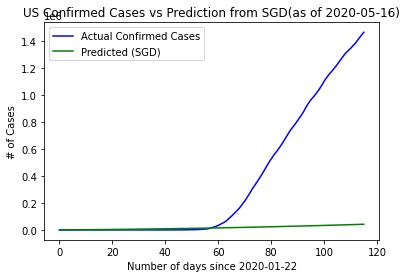

In [220]:
plot_predictions_for_country(
    df, "US", sgd_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "US Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 73821.09823070478
MSE: 12319179716.617365
RMSE: 110991.800222437
R^2: -0.4226126775785439


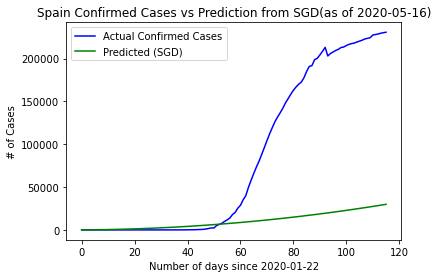

In [221]:
plot_predictions_for_country(
    df, "Spain", sgd_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Spain Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 26747.01798291352
MSE: 3188564620.500589
RMSE: 56467.376603669036
R^2: -0.06796134258844644


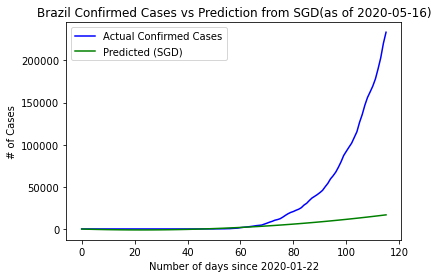

In [222]:
plot_predictions_for_country(
    df, "Brazil", sgd_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Brazil Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 2728.256127590843
MSE: 12374043.94077035
RMSE: 3517.675928901119
R^2: 0.8922065328142237


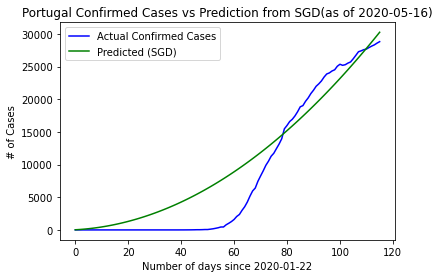

In [223]:
plot_predictions_for_country(
    df, "Portugal", sgd_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Portugal Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 32138.6012751314
MSE: 4841204924.689996
RMSE: 69578.76777214436
R^2: -0.00808298980418165


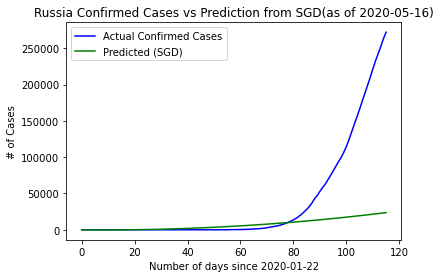

In [224]:
plot_predictions_for_country(
    df, "Russia", sgd_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Russia Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 73938.65751916353
MSE: 11501995610.0219
RMSE: 107247.35712371611
R^2: -0.5247094061109121


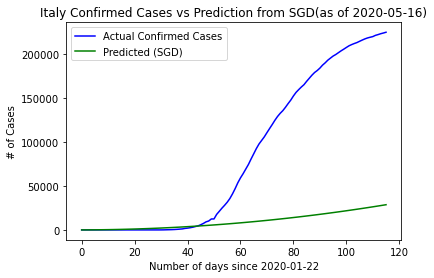

In [225]:
plot_predictions_for_country(
    df, "Italy", sgd_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Italy Confirmed Cases vs Prediction from SGD",
    True
)

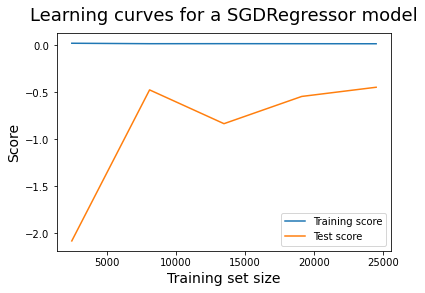

In [226]:
# learning curve

sgd_estimator_2 = clone(sgd_estimator)

plot_learning_curve(sgd_estimator_2, inputs, outputs)

### Using non normalized values and increment in confirmed values as output

In [227]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [228]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [229]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)


In [230]:
# hyper parameter tuning was unfeasable for SGDRegressor in normal time
sgd_estimator = SGDRegressor()
fit_model(sgd_estimator, in_conf_train, out_conf_train)
sgd_estimator

Elapsed time: 0.015193478266398112mins


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

MAE: 179708214263.56415
MSE: 4.903112424445783e+22
RMSE: 221429727553.59167
R^2: -3.335212966508568e+16


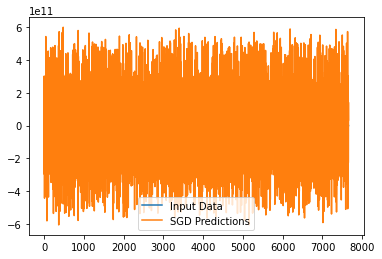

In [231]:
# Stochastic Gradient Descent doesn't do too well with non normalized valeus
check_results_test(sgd_estimator, in_conf_test, out_conf_test, 'SGD Predictions')

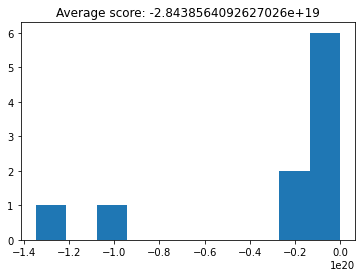

In [232]:
sgd_estimator_2 = clone(sgd_estimator)

plot_cross_val_score(sgd_estimator_2, inputs, outputs, 10)

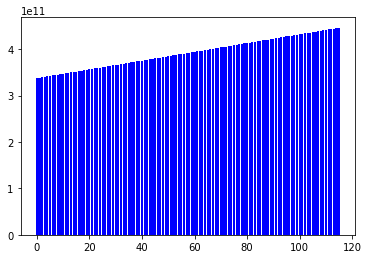

In [233]:
plot_pred_diff(
    df, sgd_estimator,
    "US", 
  ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

MAE: 21872722483999.79
MSE: 6.513516209534157e+26
RMSE: 25521591270009.316
R^2: -2807339548921567.0


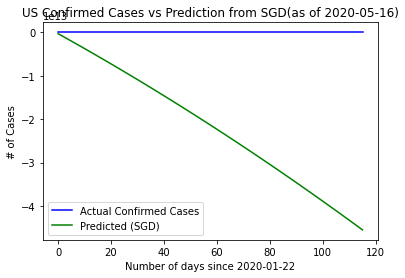

In [234]:
plot_predictions_for_country(
    df, "US", sgd_estimator, 
   ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "US Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 5926301230351.293
MSE: 5.146020597067071e+25
RMSE: 7173576930002.961
R^2: -5942598702893253.0


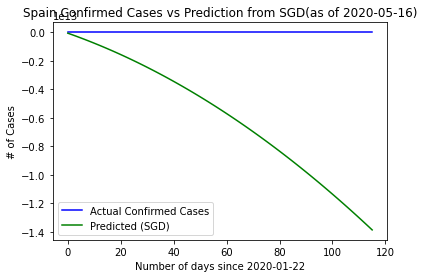

In [235]:
plot_predictions_for_country(
    df, "Spain", sgd_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Spain Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 9544529507380.75
MSE: 1.28354224759719e+26
RMSE: 11329352353939.7
R^2: -4.299030018710058e+16


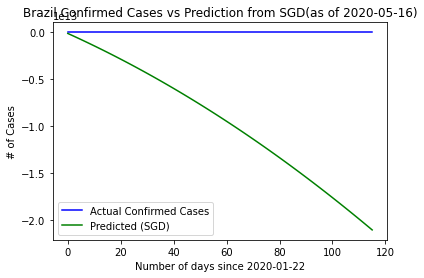

In [236]:
plot_predictions_for_country(
    df, "Brazil", sgd_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Brazil Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 6619144332979.572
MSE: 6.3493503414982445e+25
RMSE: 7968281082829.749
R^2: -5.531081762464473e+17


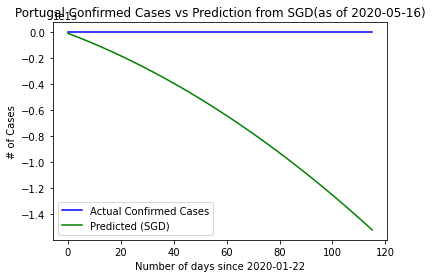

In [237]:
plot_predictions_for_country(
    df, "Portugal", sgd_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Portugal Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 8895754239661.62
MSE: 9.933736084863974e+25
RMSE: 9966812973495.576
R^2: -2.068499583912285e+16


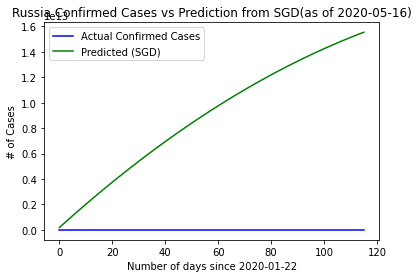

In [238]:
plot_predictions_for_country(
    df, "Russia", sgd_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Russia Confirmed Cases vs Prediction from SGD",
    True
)

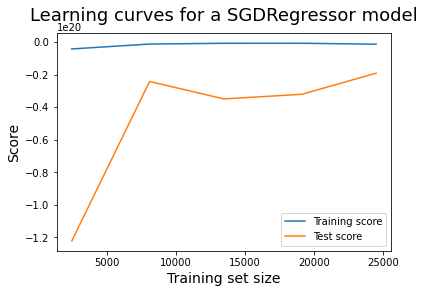

In [239]:
# learning curve

sgd_estimator_2 = clone(sgd_estimator)

plot_learning_curve(sgd_estimator_2, inputs, outputs)

### Using increases in confirmed cases and normalized values, using increase as output

In [240]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [241]:
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [242]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)


In [243]:
# hyper parameter tuning was unfeasable for SGDRegressor in normal time
sgd_estimator = SGDRegressor()
fit_model(sgd_estimator, in_conf_train, out_conf_train)
sgd_estimator

Elapsed time: 0.001252166430155436mins


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

MAE: 45.30402000780001
MSE: 186382.4285753079
RMSE: 431.7203129055985
R^2: 0.8861738823105543


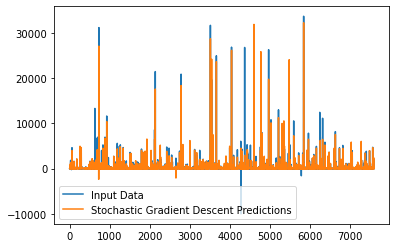

In [244]:
check_results_test(sgd_estimator, in_conf_test, out_conf_test, 'Stochastic Gradient Descent Predictions')

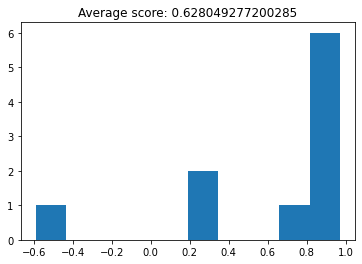

In [245]:
sgd_estimator_2 = clone(sgd_estimator)

plot_cross_val_score(sgd_estimator_2, inputs, outputs, 10)

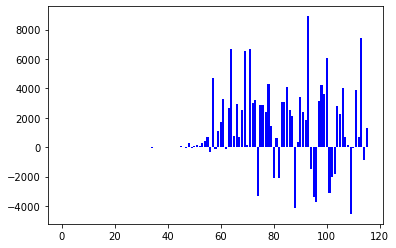

In [246]:
plot_pred_diff(
    new_df, sgd_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

MAE: 31239.682382015428
MSE: 2303859692.4300284
RMSE: 47998.53844056117
R^2: 0.9901090851426723


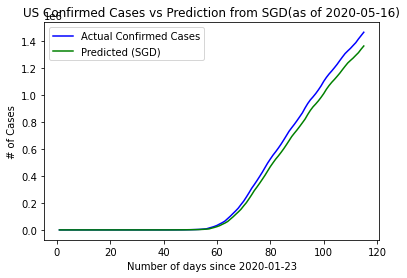

In [247]:
plot_predictions_for_country(
    new_df, "US", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "US Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 612.2996385063124
MSE: 784114.4779651463
RMSE: 885.5023873288802
R^2: 0.9931890258856308


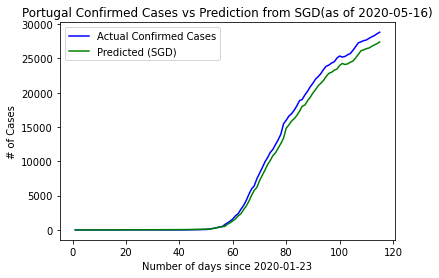

In [248]:
plot_predictions_for_country(
    new_df, "Portugal", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Portugal Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 6212.523853440337
MSE: 68638380.8794983
RMSE: 8284.828355463878
R^2: 0.9909077469588846


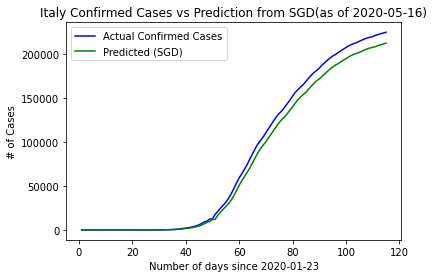

In [249]:
plot_predictions_for_country(
    new_df, "Italy", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Italy Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 4127.4295355992135
MSE: 66609894.5852381
RMSE: 8161.48850303902
R^2: 0.9862160962375975


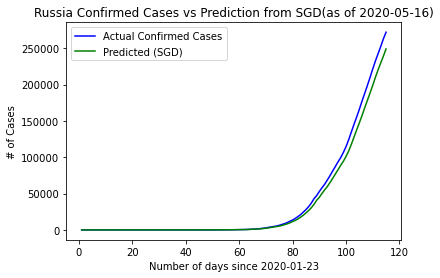

In [250]:
plot_predictions_for_country(
    new_df, "Russia", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Russia Confirmed Cases vs Prediction from SGD",
    True
)

MAE: 6238.916001410369
MSE: 77270515.97808425
RMSE: 8790.3649513592
R^2: 0.9910931015077931


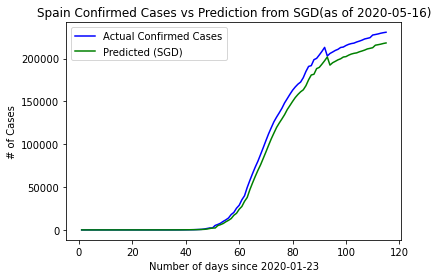

In [251]:
plot_predictions_for_country(
    new_df, "Spain", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Spain Confirmed Cases vs Prediction from SGD",
    True
)

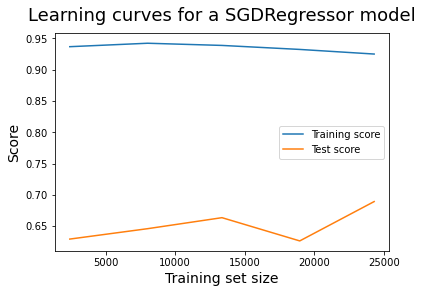

In [252]:
# learning curve

sgd_estimator_2 = clone(sgd_estimator)

plot_learning_curve(sgd_estimator_2, inputs, outputs)

### 3.4.2) Regression for Death Cases
### Using the best combination of parameters found for the confirmed deaths, for K nearest neighbours the best option tested was using increases in confirmed cases and normalized values, using increases as output

In [253]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Deaths_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11017732],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11017732],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11017732],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11017732],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11017732],
       [-1.65599721,  0.09994051,  1.71718314, -0.11017732]])

In [254]:
outputs = new_df["Deaths_inc"].values
outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [255]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [256]:
# hyper parameter tuning was unfeasable for SGDRegressor in normal time
sgd_estimator = SGDRegressor()
fit_model(sgd_estimator, in_conf_train, out_conf_train)
sgd_estimator

Elapsed time: 0.0009308576583862305mins


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

MAE: 3.9196366992668796
MSE: 1222.3639982902937
RMSE: 34.96232255286101
R^2: 0.8898223701325189


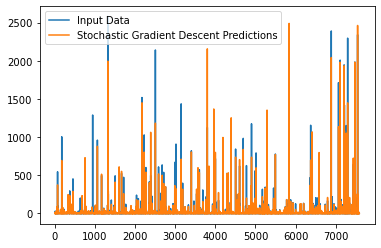

In [257]:
check_results_test(sgd_estimator, in_conf_test, out_conf_test, 'Stochastic Gradient Descent Predictions')

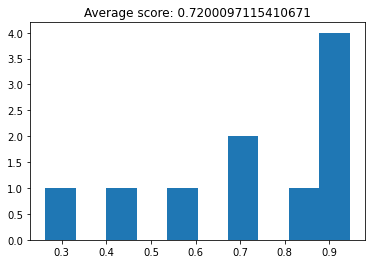

In [258]:
sgd_estimator_2 = clone(sgd_estimator)

plot_cross_val_score(sgd_estimator_2, inputs, outputs, 10)

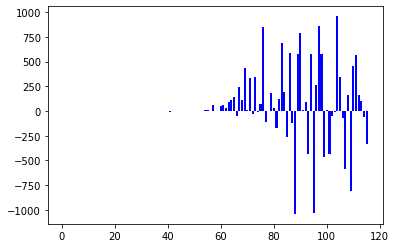

In [259]:
plot_pred_diff(
    new_df, sgd_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths_inc"
)

MAE: 1622.4304865679221
MSE: 6729519.58809839
RMSE: 2594.131759972571
R^2: 0.9918073734929251


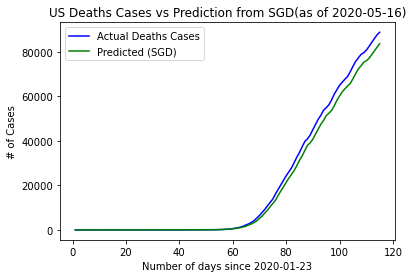

In [260]:
plot_predictions_for_country(
    new_df, "US", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SGD)", 
    "US Deaths Cases vs Prediction from SGD",
    True
)

MAE: 745.406192540118
MSE: 1040227.8826841092
RMSE: 1019.9156252769683
R^2: 0.9927342833815651


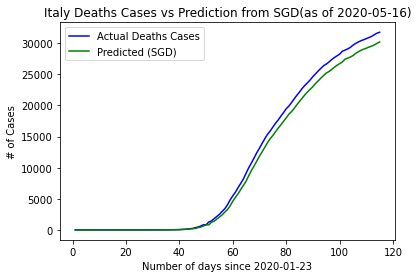

In [261]:
plot_predictions_for_country(
    new_df, "Italy", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SGD)", 
    "Italy Deaths Cases vs Prediction from SGD",
    True
)

MAE: 618.4886956410334
MSE: 776452.995683864
RMSE: 881.1657027391976
R^2: 0.9930518086754548


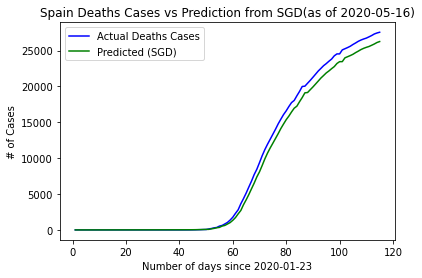

In [262]:
plot_predictions_for_country(
    new_df, "Spain", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SGD)", 
    "Spain Deaths Cases vs Prediction from SGD",
    True
)

MAE: 16.56162486246426
MSE: 421.63075879795787
RMSE: 20.53364942717095
R^2: 0.9976934394288589


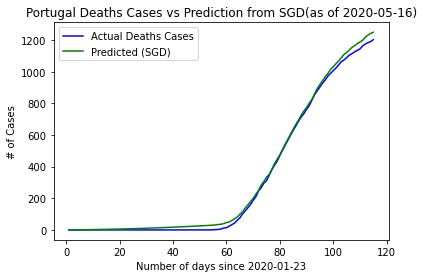

In [263]:
plot_predictions_for_country(
    new_df, "Portugal", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SGD)", 
    "Portugal Deaths Cases vs Prediction from SGD",
    True
)

MAE: 745.406192540118
MSE: 1040227.8826841092
RMSE: 1019.9156252769683
R^2: 0.9927342833815651


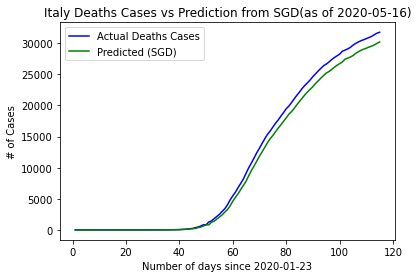

In [264]:
plot_predictions_for_country(
    new_df, "Italy", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SGD)", 
    "Italy Deaths Cases vs Prediction from SGD",
    True
)

MAE: 30.38479561696556
MSE: 3239.410670368082
RMSE: 56.91582091447054
R^2: 0.9921745210080767


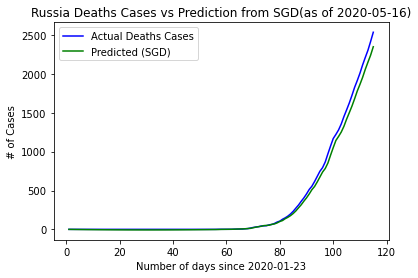

In [265]:
plot_predictions_for_country(
    new_df, "Russia", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SGD)", 
    "Russia Deaths Cases vs Prediction from SGD",
    True
)

MAE: 745.406192540118
MSE: 1040227.8826841092
RMSE: 1019.9156252769683
R^2: 0.9927342833815651


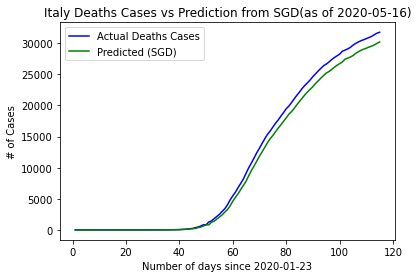

In [266]:
plot_predictions_for_country(
    new_df, "Italy", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (SGD)", 
    "Italy Deaths Cases vs Prediction from SGD",
    True
)

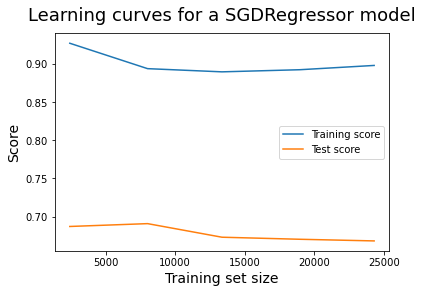

In [267]:
# learning curve

sgd_estimator_2 = clone(sgd_estimator)

plot_learning_curve(sgd_estimator_2, inputs, outputs)

### 3.4.3) Regression for Recovered Cases
### Using the best combination of parameters found for the confirmed deaths, for K nearest neighbours the best option tested was using increases in confirmed cases and normalized values, using increases as output

In [268]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Recovered_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.12137308],
       [ 0.79830423, -0.03978737, -1.68731909, -0.12137308],
       [ 0.27177561, -0.30283255, -1.68731909, -0.12137308],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.12137308],
       [ 0.31790115,  1.38034566,  1.71718314, -0.12137308],
       [-1.65599721,  0.09994051,  1.71718314, -0.12137308]])

In [269]:
outputs = new_df["Recovered_inc"].values
outputs

array([ 0.,  0.,  0., ..., 59.,  0.,  0.])

In [270]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)


In [271]:
# hyper parameter tuning was unfeasable for SGDRegressor in normal time
sgd_estimator = SGDRegressor()
fit_model(sgd_estimator, in_conf_train, out_conf_train)
sgd_estimator

Elapsed time: 0.0010970473289489747mins


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

MAE: 71.90931096607396
MSE: 129372.77021994656
RMSE: 359.6842646265563
R^2: 0.4050720600759278


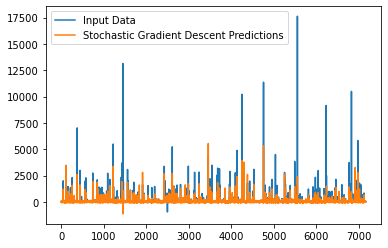

In [272]:
check_results_test(sgd_estimator, in_conf_test, out_conf_test, 'Stochastic Gradient Descent Predictions')

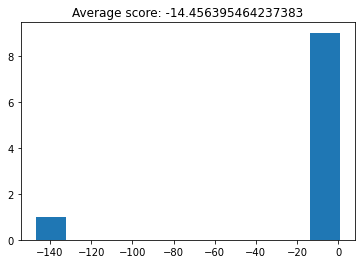

In [273]:
sgd_estimator_2 = clone(sgd_estimator)

plot_cross_val_score(sgd_estimator_2, inputs, outputs, 10)

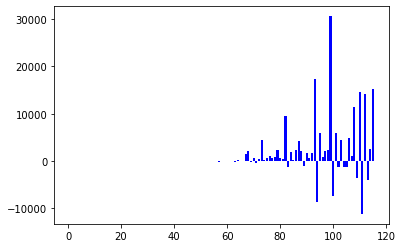

In [274]:
plot_pred_diff(
    new_df, sgd_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered_inc"
)

MAE: 20999.81414280947
MSE: 1644169788.0089333
RMSE: 40548.3635675835
R^2: 0.7070135427284192


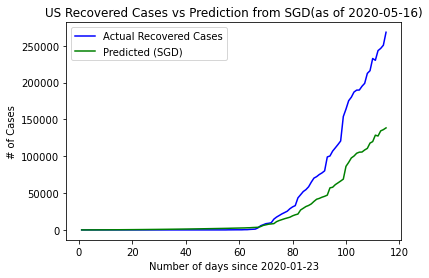

In [275]:
plot_predictions_for_country(
    new_df, "US", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SGD)", 
    "US Recovered Cases vs Prediction from SGD",
    True
)

MAE: 7252.371379247975
MSE: 174866228.11894423
RMSE: 13223.699486866155
R^2: 0.6546030920231323


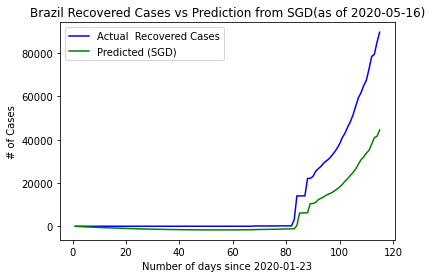

In [276]:
plot_predictions_for_country(
    new_df, "Brazil", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual  Recovered Cases", 
    "Predicted (SGD)", 
    "Brazil Recovered Cases vs Prediction from SGD",
    True
)

MAE: 1855.535197534932
MSE: 6060077.513587138
RMSE: 2461.7224688390725
R^2: -6.447938897142926


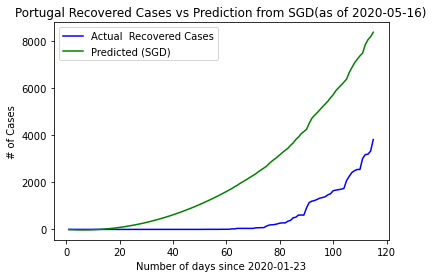

In [277]:
plot_predictions_for_country(
    new_df, "Portugal", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual  Recovered Cases", 
    "Predicted (SGD)", 
    "Portugal Recovered Cases vs Prediction from SGD",
    True
)

MAE: 2661.2926271372517
MSE: 27930886.837436058
RMSE: 5284.9680072291885
R^2: 0.8270111957676666


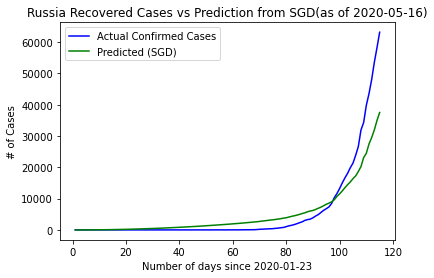

In [278]:
plot_predictions_for_country(
    new_df, "Russia", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (SGD)", 
    "Russia Recovered Cases vs Prediction from SGD",
    True
)

MAE: 16786.786811629063
MSE: 767616652.8138834
RMSE: 27705.895632768912
R^2: 0.6864240450228376


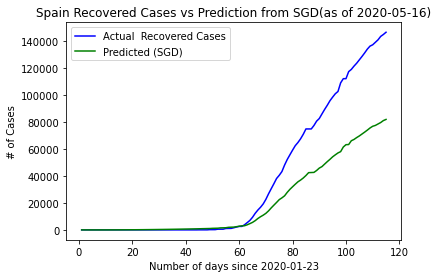

In [279]:
plot_predictions_for_country(
    new_df, "Spain", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual  Recovered Cases", 
    "Predicted (SGD)", 
    "Spain Recovered Cases vs Prediction from SGD",
    True
)

MAE: 11188.673300692557
MSE: 370172698.04594237
RMSE: 19239.872609919807
R^2: 0.7107145216599935


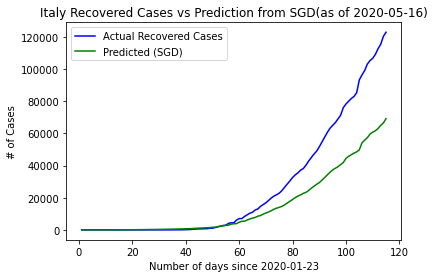

In [280]:
plot_predictions_for_country(
    new_df, "Italy", sgd_estimator, 
   ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (SGD)", 
    "Italy Recovered Cases vs Prediction from SGD",
    True
)

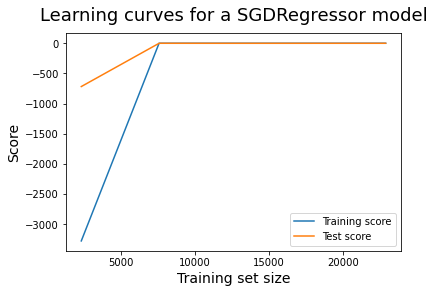

In [281]:
# learning curve

sgd_estimator_2 = clone(sgd_estimator)

plot_learning_curve(sgd_estimator_2, inputs, outputs)